In [1]:
import os
from ultralytics import YOLO
import torchvision
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from xai.drise_batch import DRISEBatch
from utils.utils import load_and_convert_bboxes
from utils.plot_utils import plot_image_with_bboxes, plot_saliency_and_targetbb_on_image

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
args = Args(**{
    'img_name': '00901',
    'model_path': 'use_case/models/best.pt',
    'datadir': 'use_case/',
    'annotations_dir': 'use_case/',
    'device': 'cuda:0',
    'input_size': (480, 640),
    'gpu_batch': 16,
    'mask_type': 'rise',
    'maskdir': 'masks/',
    'N': 1000,
    'resolution': 8,
    'p1': 0.5,
    'target_classes': [0],
})

## Data Processing

(480, 640, 3)
(480, 640, 3) uint8


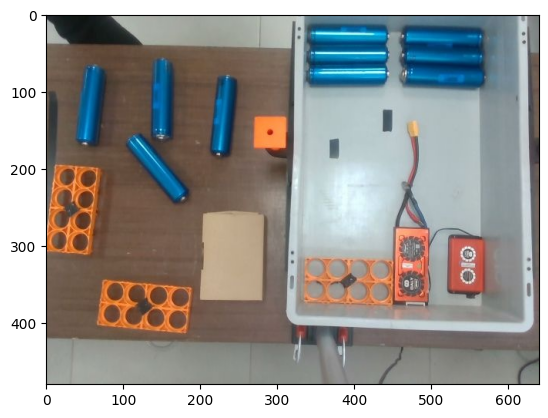

In [3]:
#########################
# Import data
#########################
height, width = args.input_size
img_path = args.datadir + args.img_name
orig_img = Image.open(img_path + '.jpg')
resized_img = orig_img.resize((width, height), Image.LANCZOS)
img_np = np.array(resized_img)

plt.imshow(img_np)
print(img_np.shape)
print(img_np.shape, img_np.dtype)

# preprocessing function
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

tensor = preprocess(img_np)
tensor = tensor.unsqueeze(0).to(args.device) # 1,3,224,224

Labels directory: use_case/00901.txt


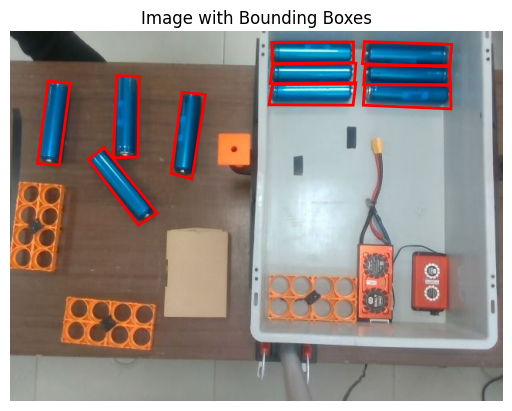

In [4]:
labels = args.annotations_dir + args.img_name + '.txt'
print('Labels directory:', labels)

for tc in [0]:#[0,1,2,3,4,5,6,7]:
    bboxes, _ = load_and_convert_bboxes(labels,img_height=args.input_size[0],img_width=args.input_size[1], target_class= tc)
    plot_image_with_bboxes(img_np,bboxes)

### set the target class

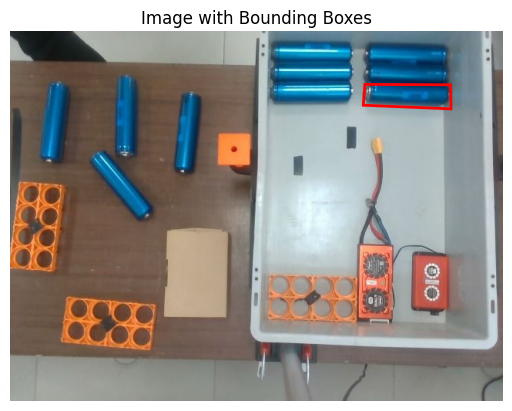

Target bbox: [(460.41984, 68.31984), (571.68, 68.84976), (572.20992, 100.11024), (458.30016, 95.34)]


In [5]:
target_class = args.target_classes[0] # select a single class (list is given)
bboxes, _ = load_and_convert_bboxes(labels,img_height=args.input_size[0],img_width=args.input_size[1], target_class= target_class)
target_bbox = bboxes[0] # select the first bbox --> multiple might be given in the same image
plot_image_with_bboxes(img_np,[target_bbox])
print('Target bbox:',target_bbox)

## YOLO
Load model and test to see its predictions

In [6]:
model = YOLO(args.model_path, task='detect')


0: 480x640 10 battery_individuals, 1 bms_a, 1 bms_b, 1 unknown_object, 3 battery_holders, 123.6ms
Speed: 0.2ms preprocess, 123.6ms inference, 645.1ms postprocess per image at shape (1, 3, 480, 640)


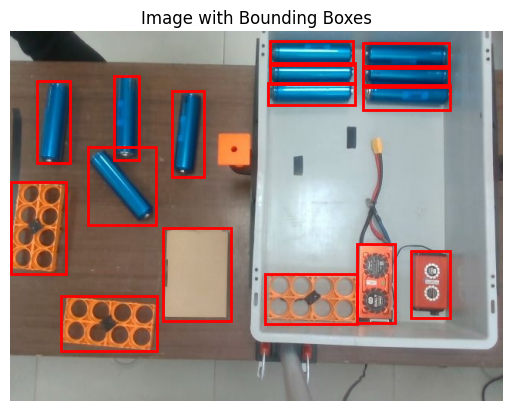

In [7]:
results=model.predict(tensor) 

boxes = results[0].boxes  # Assuming we have one image and accessing the first result
predicted_bboxes = []
for box in boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
    # Convert to a list of (x, y) tuples
    bbox = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]
    predicted_bboxes.append(bbox)
# print(bboxes)
plot_image_with_bboxes(img_np, predicted_bboxes)

## D-RISE

### Generate masks

In [8]:
explainer = DRISEBatch(
    model=model, 
    input_size=args.input_size, 
    device=args.device,
    gpu_batch=args.gpu_batch
)

# if generate or load
generate_new = True

mask_filename = f'{args.mask_type}_n{args.N}_s{args.resolution}_p{args.p1}_{args.input_size[0]}x{args.input_size[1]}'
mask_path = args.maskdir + mask_filename + '.npy'
print(mask_path)

if generate_new or not os.path.isfile(mask_path):
    explainer.generate_masks_rise(N=args.N, s=args.resolution, p1=args.p1, savepath= mask_path)
else:
    explainer.load_masks(mask_path)
    print('Masks are loaded.')

masks/rise_n1000_s8_p0.5_480x640.npy
Cell size: [         60          80]
Grid shape: (1000, 8, 8)


Generating filters: 100%|██████████| 1000/1000 [00:14<00:00, 70.18it/s]


Total time: 14.26seg


Visualize 3 generated masks

(3, 3, 480, 640)


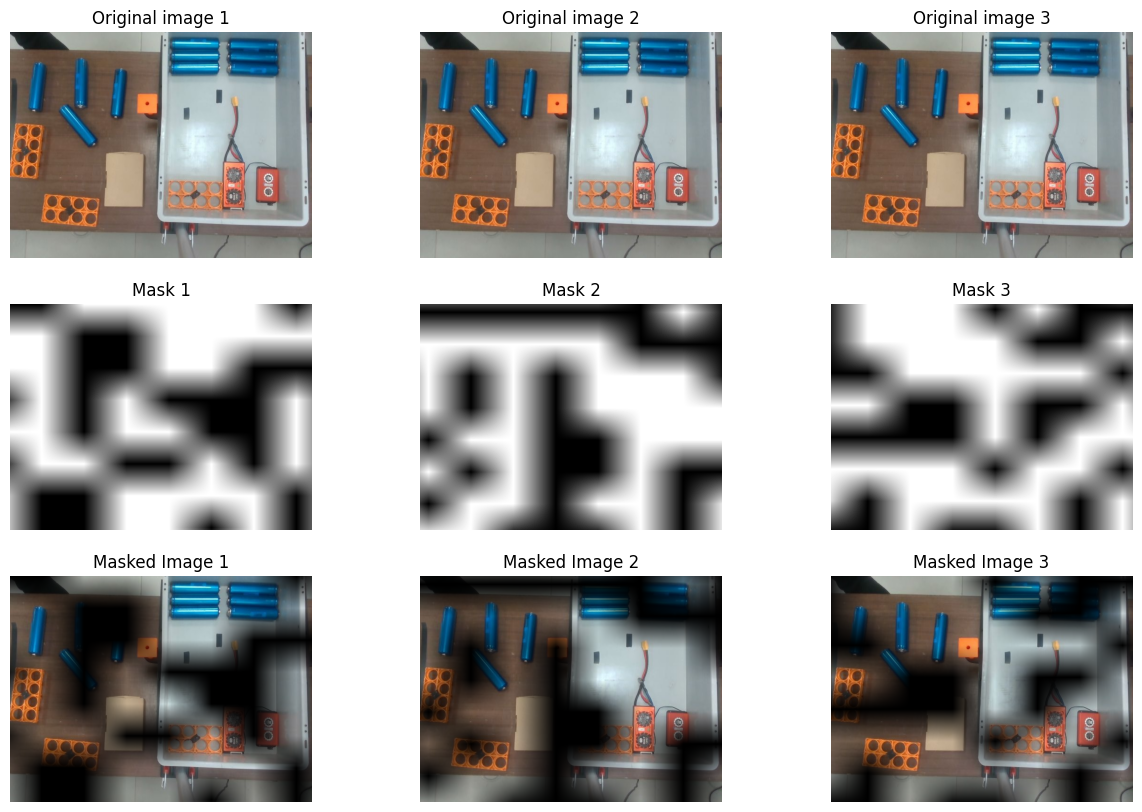

In [9]:
num_masks=3
masks = explainer.masks[:3]

masked_image = torch.mul(masks.to(args.device), tensor)
masked_image = masked_image.cpu().numpy()
print(masked_image.shape)

masks = masks.cpu()
if masks.ndim == 4:  # If the masks have a shape of (N, 1, H, W)
    masks = masks[:, 0, :, :]

fig, axes = plt.subplots(3, num_masks, figsize=(15, 10))

for i, ax in enumerate(axes[0]):
    ax.imshow(img_np)
    ax.axis('off')
    ax.set_title(f'Original image {i + 1}')

for i, ax in enumerate(axes[1]):
    ax.imshow(masks[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Mask {i + 1}')

for i, ax in enumerate(axes[2]):
    ax.imshow(masked_image[i].transpose(1, 2, 0))
    ax.axis('off')
    ax.set_title(f'Masked Image {i + 1}')
    
plt.show()

### Apply XAI

In [10]:
# print(tensor.permute(0,1,3,2).shape)
saliency = explainer(
    x=tensor,
    target_class_indices=args.target_classes,
    target_bbox=target_bbox
)

100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


### Plot heatmap/saliency map given by XAI

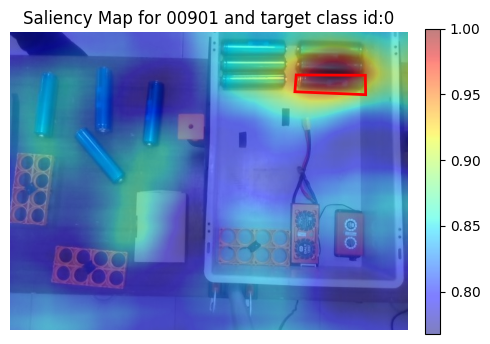

In [11]:
plot_saliency_and_targetbb_on_image(
        height=args.input_size[0], width=args.input_size[1], 
        img_name=args.img_name, 
        img=img_np,
        saliency_map=saliency[target_class], 
        target_class_id= target_class,
        target_bbox=target_bbox
    )

## do the same for another target bbox

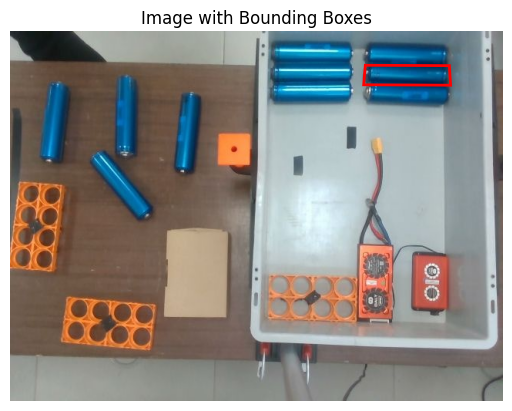

Target bbox: [(460.94976, 43.47), (570.09024, 43.95), (571.68, 69.38016), (458.83007999999995, 68.84976)]


In [12]:
bboxes, _ = load_and_convert_bboxes(labels,img_height=args.input_size[0],img_width=args.input_size[1], target_class= target_class)
target_bbox = bboxes[1] # select the first bbox --> multiple might be given in the same image
plot_image_with_bboxes(img_np,[target_bbox])
print('Target bbox:',target_bbox)

In [13]:
saliency = explainer(x=tensor,
                     target_class_indices=[target_class],
                     target_bbox=target_bbox)

100%|██████████| 63/63 [00:13<00:00,  4.83it/s]


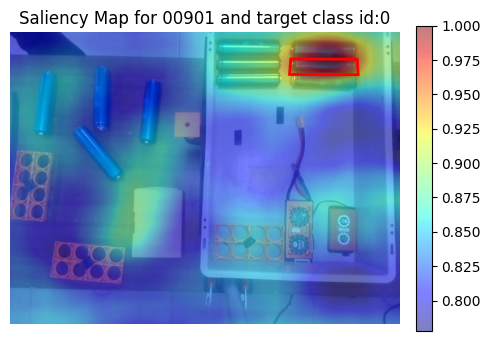

In [14]:
plot_saliency_and_targetbb_on_image(
        height=args.input_size[0], width=args.input_size[1], 
        img_name=args.img_name, 
        img=img_np,
        saliency_map=saliency[target_class], 
        target_class_id= target_class,
        target_bbox=target_bbox
    )